In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft
from scipy.stats import mode, skew, kurtosis

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import clone_model

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
# Loading Data
files = {
    "motor_OFF": "motor_off_refined.csv",
    "motor_ON": "motor_on_refined.csv",
    "motor_ON_NO_FAN": "motor_no_fan_refined.csv",

}

# Read each into a DataFrame and tag with its source
dataframes = {}
for label, path in files.items():
    df = pd.read_csv(path)
    df['source'] = label
    dataframes[label] = df

# Combine into one DataFrame (we’ll still use 'dataframes' for segmentation)
all_df = pd.concat(dataframes.values(), ignore_index=True)
print("Combined shape:", all_df.shape)

Combined shape: (27000, 6)


## EDA

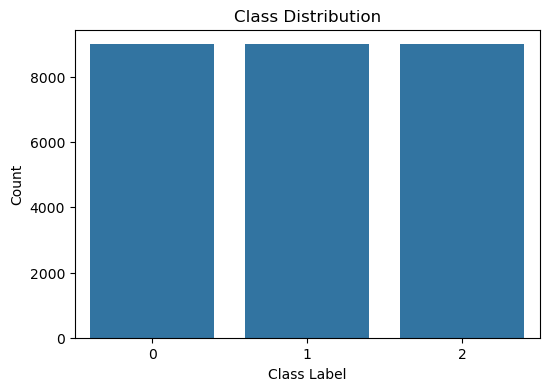

In [4]:
# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=all_df, x="class_label")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [5]:
# 2. Signal Stats Summary
print("Signal Statistics Summary:")
print(all_df[['a_x', 'a_y', 'a_z']].describe())

Signal Statistics Summary:
                a_x           a_y           a_z
count  27000.000000  27000.000000  27000.000000
mean       0.012646     -0.297545      0.694464
std        0.171232      0.618485      0.550827
min       -0.701012     -2.212592     -1.059448
25%        0.013908     -0.612440      0.421632
50%        0.030012      0.030744      0.961604
75%        0.051728      0.082960      1.005768
max        0.701744      0.397964      1.742892


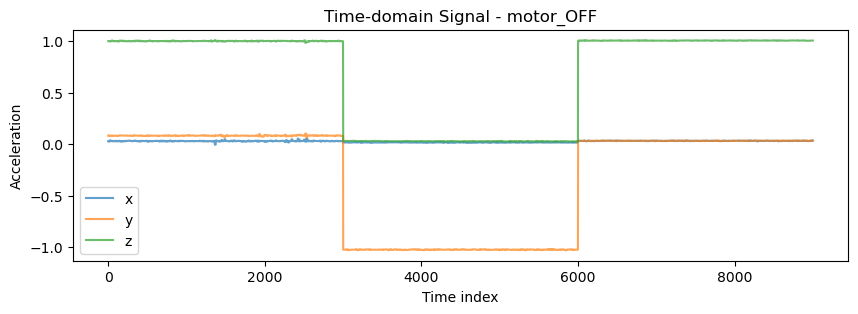

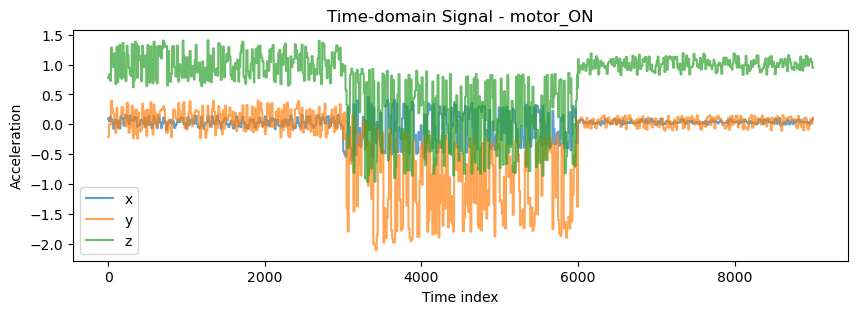

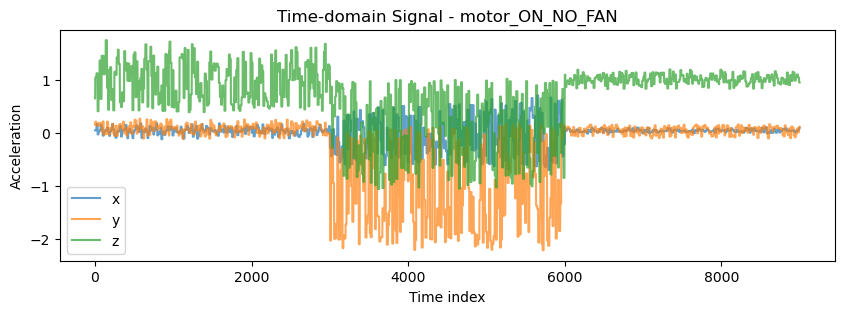

In [6]:
# 3. Time-domain Plots (Sample 200 points for readability)
for name, df in dataframes.items():
    plt.figure(figsize=(10, 3))
    plt.plot(df["a_x"][:9000], label="x", alpha=0.7)
    plt.plot(df["a_y"][:9000], label="y", alpha=0.7)
    plt.plot(df["a_z"][:9000], label="z", alpha=0.7)
    plt.title(f"Time-domain Signal - {name}")
    plt.xlabel("Time index")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.show()

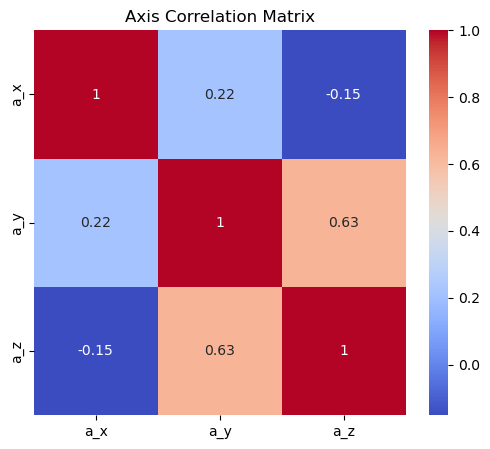

In [7]:
# 4. Correlation Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(all_df[["a_x", "a_y", "a_z"]].corr(), annot=True, cmap="coolwarm")
plt.title("Axis Correlation Matrix")
plt.show()

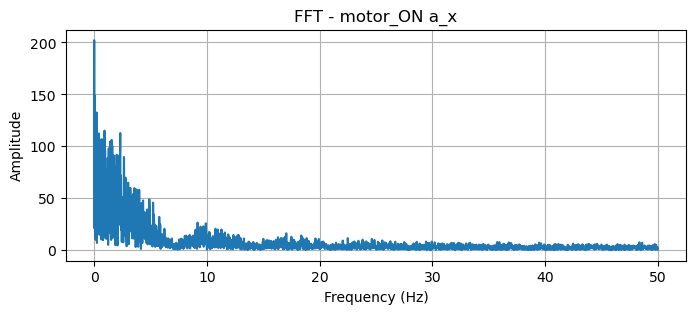

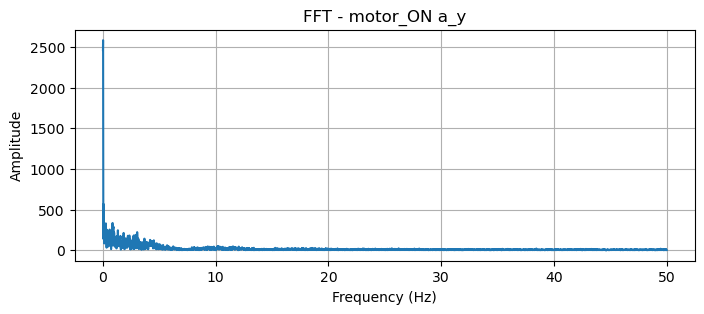

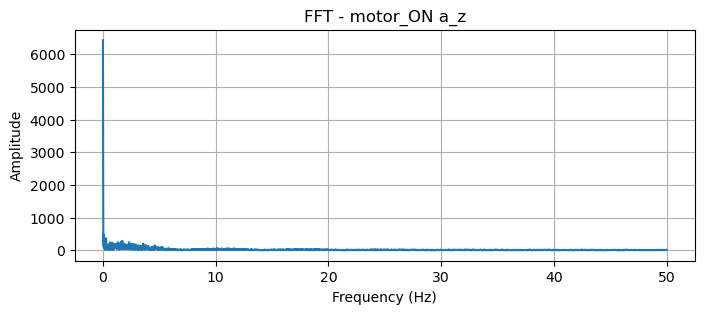

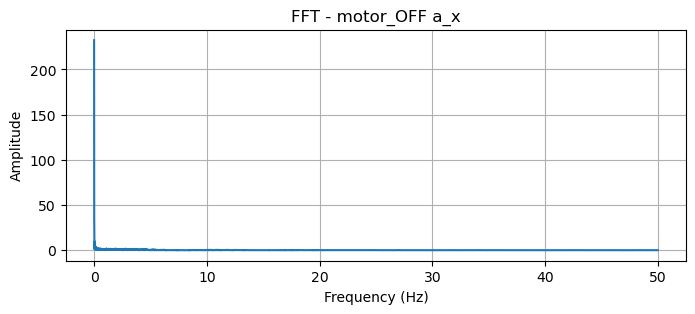

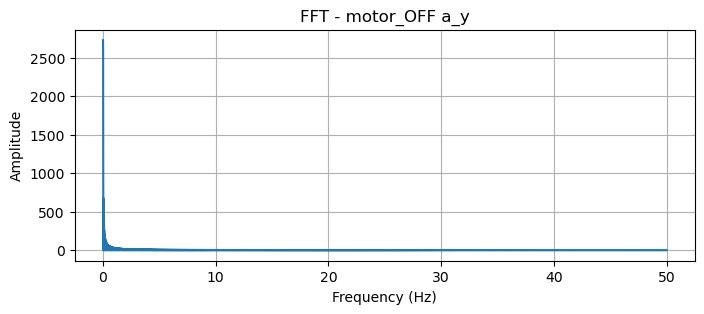

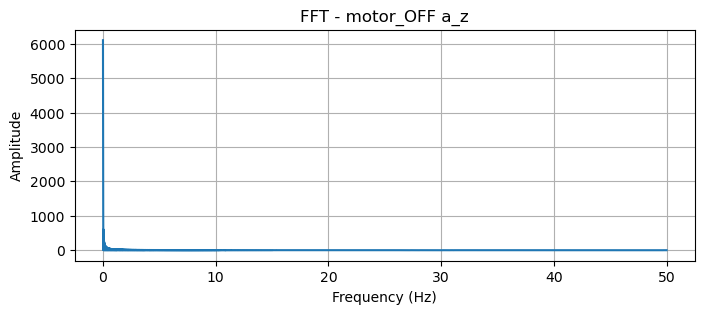

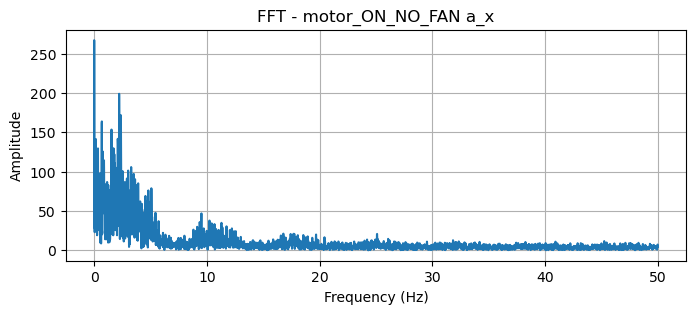

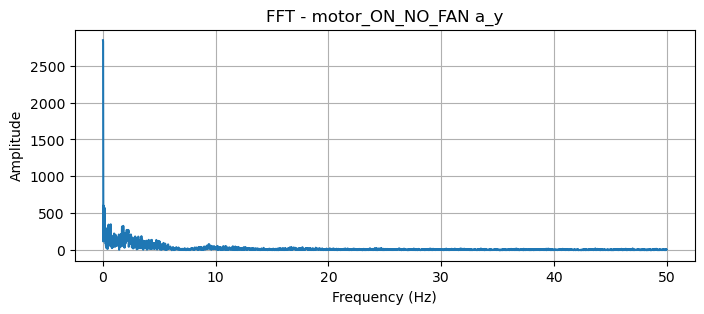

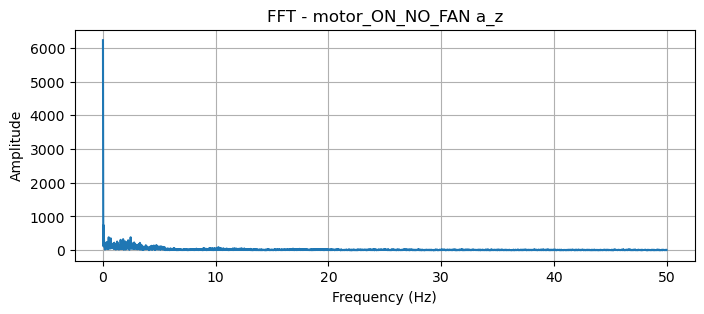

In [8]:
# 5. FFT for Frequency Analysis
def plot_fft(signal, title):
    signal = pd.to_numeric(signal, errors="coerce").dropna().to_numpy()
    N = len(signal)
    fft_vals = np.abs(fft(signal))[:N // 2]
    freqs = np.fft.fftfreq(N, d=1/100)[:N // 2]  # Assuming 100 Hz sampling
    plt.figure(figsize=(8, 3))
    plt.plot(freqs, fft_vals)
    plt.title(f"FFT - {title}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# For MOTOR_ON
plot_fft(dataframes["motor_ON"]["a_x"], "motor_ON a_x")
plot_fft(dataframes["motor_ON"]["a_y"], "motor_ON a_y")
plot_fft(dataframes["motor_ON"]["a_z"], "motor_ON a_z")

# For MOTOR_OFF
plot_fft(dataframes["motor_OFF"]["a_x"], "motor_OFF a_x")
plot_fft(dataframes["motor_OFF"]["a_y"], "motor_OFF a_y")
plot_fft(dataframes["motor_OFF"]["a_z"], "motor_OFF a_z")

# For MOTOR_ON_NO_FAN
plot_fft(dataframes["motor_ON_NO_FAN"]["a_x"], "motor_ON_NO_FAN a_x")
plot_fft(dataframes["motor_ON_NO_FAN"]["a_y"], "motor_ON_NO_FAN a_y")
plot_fft(dataframes["motor_ON_NO_FAN"]["a_z"], "motor_ON_NO_FAN a_z")

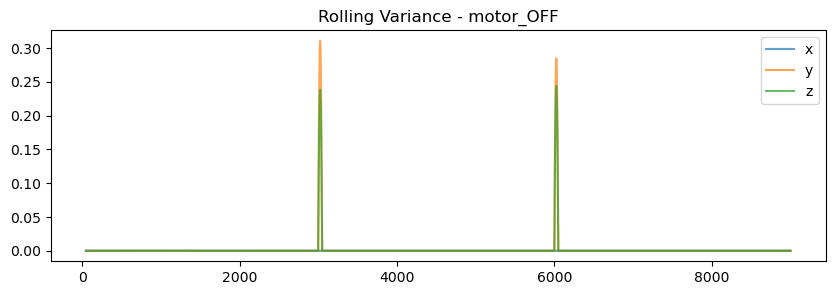

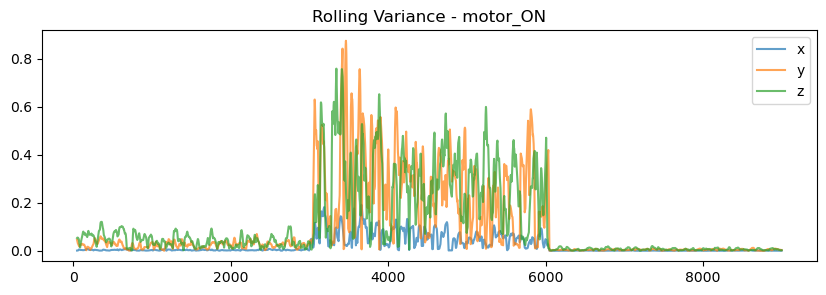

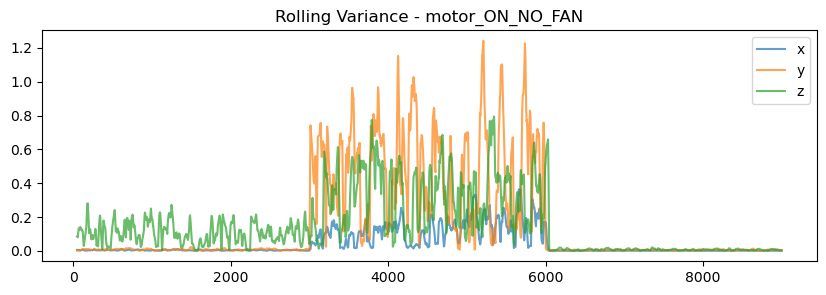

In [9]:
# 6. Rolling Variance (Signal Stability)
roll_window = 50
for name, df in dataframes.items():
    plt.figure(figsize=(10, 3))
    plt.plot(df['a_x'].rolling(roll_window).var(), label="x", alpha=0.7)
    plt.plot(df['a_y'].rolling(roll_window).var(), label="y", alpha=0.7)
    plt.plot(df['a_z'].rolling(roll_window).var(), label="z", alpha=0.7)
    plt.title(f"Rolling Variance - {name}")
    plt.legend()
    plt.show()

## Feature Extraction

In [11]:
# Segment into Windows
def segment_signal(df, window_size=100, step_size=100):
    """
    Split df into non-overlapping windows of length `window_size`.
    Returns segments: array(shape=(n_windows, 3, window_size))
            labels:   array(shape=(n_windows,))
            groups:   list of 'source' strings per window
    """
    segments, labels, groups = [], [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        x, y, z = df[['a_x','a_y','a_z']].iloc[start:end].values.T
        segments.append([x, y, z])
        labels.append(df['class_label'].iloc[start])
        groups.append(df['source'].iloc[start])
    return np.array(segments), np.array(labels), np.array(groups)

# Apply per DataFrame
all_segments, all_labels, all_groups = [], [], []
for name, df in dataframes.items():
    segs, labs, grps = segment_signal(df, window_size=100, step_size=100)
    all_segments.append(segs)
    all_labels.append(labs)
    all_groups.append(grps)

# Concatenate across sources
segments_all = np.concatenate(all_segments, axis=0)
labels_all   = np.concatenate(all_labels, axis=0)
groups_all   = np.concatenate(all_groups, axis=0)

print("Segments:", segments_all.shape)
print("Labels:", labels_all.shape)


Segments: (270, 3, 100)
Labels: (270,)


In [12]:
# Enhanced Feature Extraction
def extract_features_with_magnitude(segments, fft_bins=50, roll_win=10):
    """
    segments: array of shape (n_windows, 3, window_size)
    Returns: array of shape (n_windows, n_features)
    where n_features = 3_axes * (fft_bins*2/statistics) + magnitude features
    """
    feature_list = []
    for x, y, z in segments:
        # --- 1) Axis features (as before) ---
        def axis_feats(sig):
            # FFT
            fft_vals = np.abs(fft(sig))[:fft_bins]
            fft_mean, fft_std = fft_vals.mean(), fft_vals.std()
            # Time-domain stats
            m, s, mn, mx = sig.mean(), sig.std(), sig.min(), sig.max()
            sk, kt = skew(sig), kurtosis(sig)
            # Rolling variance
            rv = pd.Series(sig).rolling(roll_win).var().dropna()
            rv_mean, rv_std = rv.mean(), rv.std()
            return np.hstack([fft_vals, 
                              m, s, mn, mx, sk, kt, 
                              fft_mean, fft_std, 
                              rv_mean, rv_std])

        x_feats = axis_feats(x)
        y_feats = axis_feats(y)
        z_feats = axis_feats(z)

        # --- 2) Magnitude features ---
        acc = np.sqrt(x**2 + y**2 + z**2)
        # FFT on magnitude
        acc_fft = np.abs(fft(acc))[:fft_bins]
        acc_fft_mean, acc_fft_std = acc_fft.mean(), acc_fft.std()
        # Time-domain stats on magnitude
        acc_m, acc_s, acc_min, acc_max = acc.mean(), acc.std(), acc.min(), acc.max()
        acc_sk, acc_kt = skew(acc), kurtosis(acc)
        # Rolling variance on magnitude
        acc_rv = pd.Series(acc).rolling(roll_win).var().dropna()
        acc_rv_mean, acc_rv_std = acc_rv.mean(), acc_rv.std()

        mag_feats = np.hstack([
            acc_fft,
            acc_m, acc_s, acc_min, acc_max, acc_sk, acc_kt,
            acc_fft_mean, acc_fft_std,
            acc_rv_mean, acc_rv_std
        ])

        # --- 3) Concatenate all ---
        feature_list.append(np.hstack([x_feats, y_feats, z_feats, mag_feats]))

    return np.array(feature_list)

In [13]:
features_all = extract_features_with_magnitude(segments_all, fft_bins=50, roll_win=10)
print("New feature matrix shape:", features_all.shape)
 
#   3 * (50 FFT + 6 stats + 2 FFT-summaries + 2 rolling-summaries)
# + (50 FFT + 6 stats + 2 FFT-summaries + 2 rolling-summaries)
# = 3*(50+6+2+2) + (50+6+2+2) = 3*60 + 60 = 240 features per window.

New feature matrix shape: (270, 240)


## Data Prep for ML

In [15]:
# Train/Test Split
# `features_all` (n_samples × n_features) and `labels_all` (n_samples,) come from your previous steps.

# 1) Stratify on labels to ensure each class in train & test
X_train, X_test, y_train, y_test = train_test_split(
    features_all, labels_all,
    test_size=0.2,
    stratify=labels_all,
    random_state=42
)

# 2) Scale AFTER splitting (fit on train only)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3) One-hot encode
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat  = to_categorical(y_test,  num_classes=4)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

Train class counts: [72 72 72]
Test  class counts: [18 18 18]


In [16]:
# Scaling
scaler = StandardScaler().fit(X_train)  # fit on train only
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## DNN

In [18]:
# Deep Neural Network
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

inp = Input(shape=(X_train_scaled.shape[1],))
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(inp)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(1e-4))(x)
out = Dense(4, activation='softmax')(x)

model = Model(inp, out)
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        15,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,484 (72.20 KB)

 Trainable params: 18,292 (71.45 KB)

 Non-trainable params: 192 (768.00 B)

In [19]:
# Training the model
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_split = 0.2,
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, reduce_lr],
    verbose = 2
)

Epoch 1/100
6/6 - 1s - 134ms/step - accuracy: 0.2907 - loss: 1.6803 - val_accuracy: 0.2045 - val_loss: 1.5404 - learning_rate: 0.0010
Epoch 2/100
6/6 - 0s - 6ms/step - accuracy: 0.4709 - loss: 1.2930 - val_accuracy: 0.3864 - val_loss: 1.4375 - learning_rate: 0.0010
Epoch 3/100
6/6 - 0s - 6ms/step - accuracy: 0.5291 - loss: 1.1310 - val_accuracy: 0.4318 - val_loss: 1.4126 - learning_rate: 0.0010
Epoch 4/100
6/6 - 0s - 6ms/step - accuracy: 0.4826 - loss: 1.1250 - val_accuracy: 0.4091 - val_loss: 1.4372 - learning_rate: 0.0010
Epoch 5/100
6/6 - 0s - 6ms/step - accuracy: 0.6105 - loss: 0.9544 - val_accuracy: 0.4091 - val_loss: 1.5085 - learning_rate: 0.0010
Epoch 6/100
6/6 - 0s - 6ms/step - accuracy: 0.5872 - loss: 0.9680 - val_accuracy: 0.4318 - val_loss: 1.4955 - learning_rate: 0.0010
Epoch 7/100
6/6 - 0s - 6ms/step - accuracy: 0.6221 - loss: 0.9476 - val_accuracy: 0.4318 - val_loss: 1.4529 - learning_rate: 5.0000e-04
Epoch 8/100
6/6 - 0s - 6ms/step - accuracy: 0.6919 - loss: 0.8437 - va

## Model Evaluation

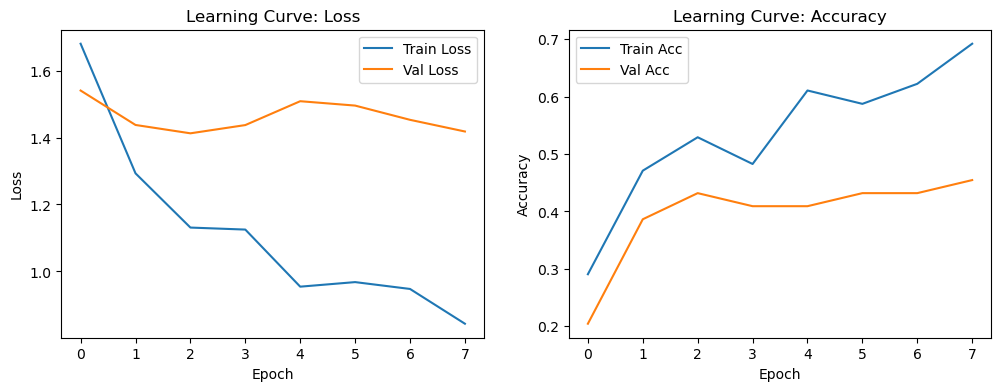

In [21]:
plt.figure(figsize=(12,4))
# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Learning Curve: Loss')

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Learning Curve: Accuracy')
plt.show()

In [22]:
gkf = GroupKFold(n_splits = 3)
val_scores = []

for train_idx, val_idx in gkf.split(features_all, labels_all, groups_all):
    # split
    X_tr, X_val = features_all[train_idx], features_all[val_idx]
    y_tr, y_val = labels_all[train_idx], labels_all[val_idx]
    # scale
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    # one-hot encode
    y_tr_c = to_categorical(y_tr, 4)
    y_val_c = to_categorical(y_val, 4)
    # clone & compile fresh model
    m = clone_model(model)
    m.set_weights(model.get_weights())  # optional: same initialization
    m.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    # train
    m.fit(
        X_tr_s, y_tr_c,
        validation_data=(X_val_s, y_val_c),
        epochs=20, batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    # evaluate
    val_scores.append(m.evaluate(X_val_s, y_val_c, verbose=0)[1])

print("GroupKFold Validation accuracies:", np.round(val_scores, 3))
print("Mean ± Std:", np.mean(val_scores), "±", np.std(val_scores))

GroupKFold Validation accuracies: [0.178 0.278 1.   ]
Mean ± Std: 0.4851851910352707 ± 0.36631108463897905


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


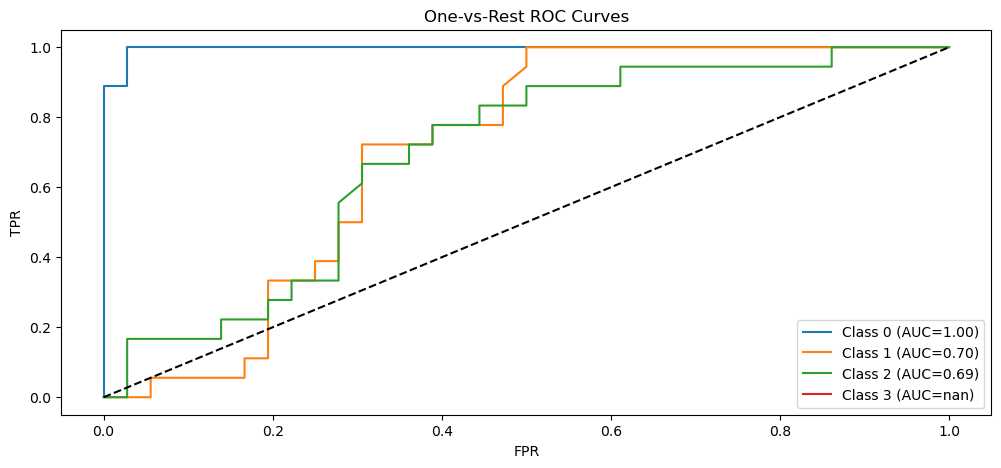

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


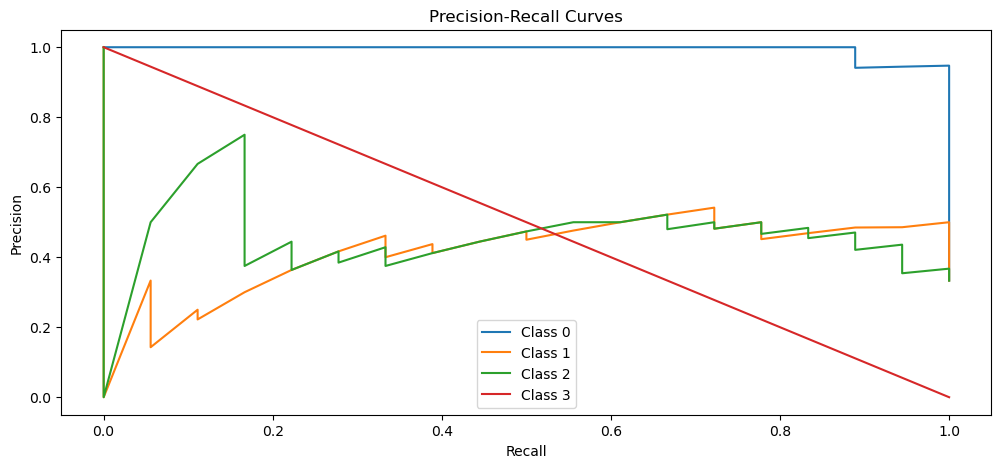

In [23]:
# Binarize test labels
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_pred_proba = model.predict(X_test_scaled)

# Plot ROC curves
plt.figure(figsize=(12,5))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_proba[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('One-vs-Rest ROC Curves'); plt.legend()
plt.show()

# Plot PR curves
plt.figure(figsize=(12,5))
for i in range(4):
    prec, rec, _ = precision_recall_curve(y_test_bin[:,i], y_pred_proba[:,i])
    plt.plot(rec, prec, label=f'Class {i}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curves'); plt.legend()
plt.show()


Hold-out Test Accuracy: 0.4815
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


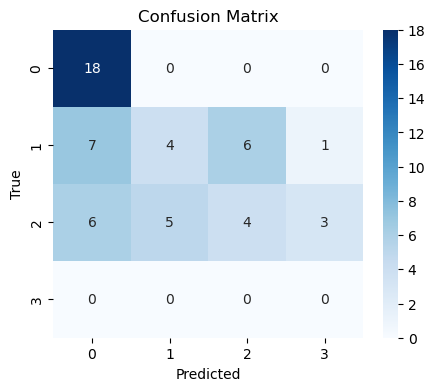


Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        18
           1       0.44      0.22      0.30        18
           2       0.40      0.22      0.29        18
           3       0.00      0.00      0.00         0

    accuracy                           0.48        54
   macro avg       0.36      0.36      0.33        54
weighted avg       0.48      0.48      0.44        54



In [24]:
# Evaluation
# Test set performance

test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"\nHold-out Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test_scaled)
y_pred_lbl = y_pred.argmax(axis=1)

# 7) Confusion Matrix & Classification Report
cm = confusion_matrix(y_test, y_pred_lbl)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lbl, zero_division=0))


## Porting the model to TensorFlow Lite

In [26]:
#import tensorflow as tf

# Convert to TFLite
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]  # enable default optimizations (quantization)
#tflite_model = converter.convert()

# Save
#with open('model_quant.tflite', 'wb') as f:
#    f.write(tflite_model)

# Report size
#import os
#size_kb = os.path.getsize('model_quant.tflite') / 1024
#print(f"Quantized TFLite model size: {size_kb:.1f} KB")

## Sanity Check

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

CV Accuracy: 0.759 ± 0.086


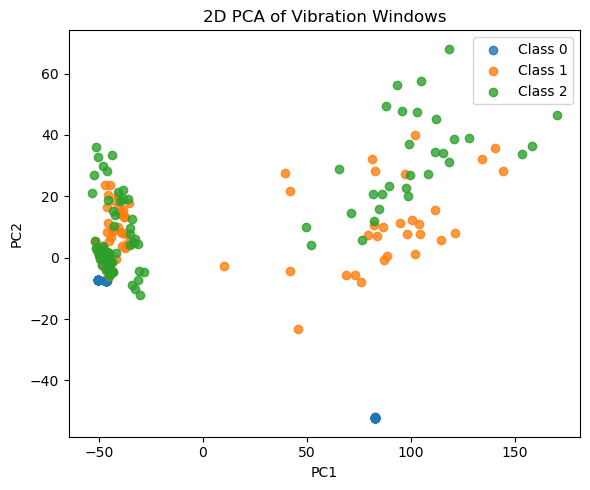

In [28]:
# PCA + Logistic Regression Baseline
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# 1) Reload & re-segment (non-overlap)
files = {
    "motor_OFF": "motor_off_refined.csv",
    "motor_ON": "motor_on_refined.csv",
    "motor_ON_NO_FAN": "motor_no_fan_refined.csv",

}

dataframes = {label: pd.read_csv(path) for label, path in files.items()}

def segment_signal(df, window_size=100, step_size=100):
    segs, labs = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        seg = df[['a_x','a_y','a_z']].iloc[start:start+window_size].values.T
        segs.append(seg)
        labs.append(df['class_label'].iloc[start])
    return np.array(segs), np.array(labs)

# gather all segments and labels
segments_list, labels_list = [], []
for df in dataframes.values():
    s, l = segment_signal(df)
    segments_list.append(s)
    labels_list.append(l)
segments_all = np.concatenate(segments_list, axis=0)
labels_all   = np.concatenate(labels_list, axis=0)

# 2) Feature extraction (including vector magnitude)
def extract_features_with_magnitude(segs, fft_bins=50, roll_win=10):
    feats = []
    for x, y, z in segs:
        def axis_feats(sig):
            vals = np.abs(fft(sig))[:fft_bins]
            m, s, mn, mx = sig.mean(), sig.std(), sig.min(), sig.max()
            sk, kt = skew(sig), kurtosis(sig)
            rv = pd.Series(sig).rolling(roll_win).var().dropna()
            rv_m, rv_s = rv.mean(), rv.std()
            return np.hstack([vals, m, s, mn, mx, sk, kt, vals.mean(), vals.std(), rv_m, rv_s])
        x_f, y_f, z_f = axis_feats(x), axis_feats(y), axis_feats(z)
        acc = np.sqrt(x**2 + y**2 + z**2)
        a_vals = np.abs(fft(acc))[:fft_bins]
        a_stats = [acc.mean(), acc.std(), acc.min(), acc.max(), skew(acc), kurtosis(acc)]
        a_rv = pd.Series(acc).rolling(roll_win).var().dropna()
        a_feats = np.hstack([a_vals, *a_stats, a_vals.mean(), a_vals.std(), a_rv.mean(), a_rv.std()])
        feats.append(np.hstack([x_f, y_f, z_f, a_feats]))
    return np.array(feats)

features_all = extract_features_with_magnitude(segments_all)

# 3) PCA to 10 components for modeling
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(features_all)

# 4) Logistic Regression with 5-fold Stratified CV
clf = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_pca, labels_all, cv=cv, scoring='accuracy')
print(f"CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# 5) PCA to 2 components for scatter plot
pca2 = PCA(n_components=2, random_state=42)
X_vis = pca2.fit_transform(features_all)
df_vis = pd.DataFrame(X_vis, columns=['PC1','PC2'])
df_vis['label'] = labels_all

plt.figure(figsize=(6,5))
for lbl in sorted(df_vis['label'].unique()):
    subset = df_vis[df_vis['label']==lbl]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Class {lbl}', alpha=0.8)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('2D PCA of Vibration Windows')
plt.legend()
plt.tight_layout()
plt.show()